Validating Defensive Pass Reads
===============================

Can analytics predict the actions of the offense by analyzing the pre-snap motion of the defense? 

This notebook will explore the validity of predicting the pass by observing motions from the defense, especially linebackers, safeties and cornerbacks. While the defensive line (tackles and ends) tend to cover the area immediately closest to the football, the linebackers and the secondary show the most variability and versatility in responding to different potential offensive plays. Thus, we can measure their movements to get an idea of what the defense _thinks_ the offense will do.

This notebook uses 5-fold cross-validation by mapping the false positive rate (FPR) againt the true positive rate (TPR) to show variance of the [Receiver Operating Curve (ROC)](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html). By analyizing different subsets of the motion event data, this model can calculate the average Area Under Curve (AUC), to give an idea of how well defensive motion events and alignments act as indicators for what the offense will do.

# Load Week 4 Data

In the interest of iterating quickly, this initial notebook isolates motion events for only Week 4. Once the model, thresholds and features have been tuned, the data for this notebook can be expanded to include data from Weeks 1 through 6. Weeks 7 through 8 will be used for validating the final model, and week 9 will be used for final training.

In [33]:
import pandas as pd
import analyze_play as ap

import glob

motion_filename  = f"../{ap.PROCESSED_DATA_DIR}/motion.week4.2025*"
plays_filename   = f"../{ap.RAW_DATA_DIR}/plays.csv"

motion_files_found = glob.glob(motion_filename)
if len(motion_files_found) > 1:
    print(f"ERROR: Motion file {motion_filename} is not specific enough; " \
          f"found {len(motion_files_found)} files")
    sys.exit(1)

df_motion = pd.read_csv(motion_files_found[0])

df_motion["game.play"] = df_motion.agg('{0[gameId]}.{0[playId]}'.format, axis = 1)

list_plays = df_motion["game.play"].unique()
list_games = df_motion["gameId"].unique()

print(f"Reading file: \"{motion_files_found[0]}\"")
print(f"Found {len(df_motion)} motion events in {len(list_plays)} plays from {len(list_games)} game(s)")

Reading file: "../data/processed/motion.week4.20250102.222806.csv"
Found 10021 motion events in 1735 plays from 16 game(s)


# Load Play Result Data

Load the play data, as provided by the NFL Big Data Bowl dataset

In [34]:
df_plays  = pd.read_csv(plays_filename)

df_focused = df_plays[ df_plays[ "gameId" ].isin( list_games ) ]
print(f"Reading file: \"{plays_filename}\"")
print(f"Found {len(df_focused)} plays from {len(list_games)} game(s)")

Reading file: "../data/kaggle/plays.csv"
Found 1830 plays from 16 game(s)


 # Merge Motion Events with Play Results

In [35]:
df_merged = df_motion.merge( df_plays, on=[ 'gameId', 'playId' ] )

list_merged_plays = df_merged["game.play"].unique()

print(f"Merged data shape: {df_merged.shape}")
print(f"Found {len(list_merged_plays)} total plays from merged data")

Merged data shape: (10021, 67)
Found 1735 total plays from merged data


# ROC Analysis

There are 2 columns in our data to explore: "motionDirRelativetoScrimmage" and "isDropback". The first value tells us whether the player was moving towards the line of scrimmage (forward), or away (back). To calculate the probability of any given motion event to predict the pass, we will convert the motion direction to "1" if the player is moving back, and to 0 if there's any other value in the column.

In the play result data, we use the "isDropback" column to determine if a Quarterback intends to pass on the play. And, like the column described above, its data is not in integers, so it will need to be converted.

## Functions



In [36]:
def convert_motiondir_to_int( df_row ):

    if (df_row[ "motionDirRelativeToScrimmage" ] == "back"):
        return 1
    else:
        return 0

def convert_isdropback_to_int( df_row ):
    if (df_row["isDropback"]):
        return 1
    else:
        return 0

## Plot the Curve

In [37]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score

df_player = df_merged[ df_merged[ 'nflId' ] == 44925 ]

test = df_player.apply(convert_motiondir_to_int, axis = 1)
pred = df_player.apply(convert_isdropback_to_int, axis = 1)

#print(test)

fpr, tpr, roc_auc = {}, {}, {}

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(test, pred)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
print(f"Player has {len(df_player)} motion events")
print(f"Area Under Curve: {roc_auc_score(test, pred)}")

Player has 61 motion events
Area Under Curve: 0.6241258741258742


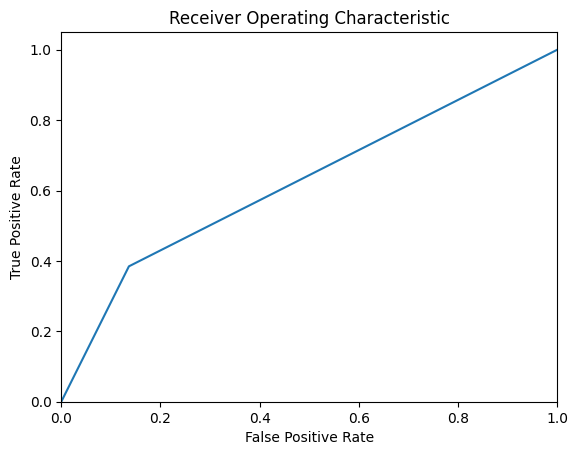

In [38]:
plt.figure()

plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic')
plt.show()